Building three RNN models for Sentiment Analysis, using three different architectures [Tanh, the traditional architecture, LSTM and GRU, the Gated Unit Architecture]

In [32]:
# importing the required libraries

import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.layers.embeddings import Embedding
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
data = pd.read_csv('IMDB_Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [34]:
x_train, x_val, y_train, y_val = train_test_split(data['review'], data['sentiment'], test_size=0.2, random_state=42)	

In [35]:
import tensorflow as tf
from tensorflow.python.keras.layers.embeddings import Embedding

# GRU layer
class GRU(tf.keras.layers.Layer):
  '''
    Arguments:
      units (int): hidden dimension 
      inp_shape (int): Embedding dimension 
    Output:
      h_t (Tensor): 
        Current hidden state
        shape=(None, units) 
  '''

  def __init__(self, units, inp_shape):
    super(GRU, self).__init__()
    self.units = units
    self.inp_shape = inp_shape
    self.W = self.add_weight("W", shape=(3, self.units, self.inp_shape))
    self.U = self.add_weight("U", shape=(3, self.inp_shape, self.units))
    
  def call(self, pre_h, x):

    # Update gate: Decide how much the unit updates its activation, or content
    z_t = tf.nn.sigmoid(
        tf.matmul(x, tf.transpose(self.W[0])) + tf.matmul(pre_h, tf.transpose(self.U[0])))

    # Reset gate: Forget the previously state
    r_t = tf.nn.sigmoid(
        tf.matmul(x, tf.transpose(self.W[1])) + tf.matmul(pre_h, tf.transpose(self.U[1])))

    # Current memory content
    h_proposal = tf.nn.tanh(
        tf.matmul(x, tf.transpose(self.W[2])) + tf.matmul(tf.multiply(r_t, pre_h), tf.transpose(self.U[2])))

    # Current hidden state
    h_t = tf.multiply((1 - z_t), pre_h) + tf.multiply(z_t, h_proposal)
    
    return h_t

# Define GRU model
class GRU_RNN(tf.keras.Model):
  """
    Using GRU cell and Dense layers for training model
  """
  def __init__(self, units, embedding_size, vocab_size, input_length, num_class):
    super(GRU_RNN, self).__init__()
    self.input_length = input_length
    self.units = units
    self.num_class = num_class

    # Embedding
    self.embedding = tf.keras.layers.Embedding(
      vocab_size,
      embedding_size,
      input_length=input_length
    )

    # Using gru cell
    self.model = GRU(units, embedding_size)

    # Pass each hidden state through Rnn basic
    self.classification_layer = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, input_shape=(units,), activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_class, activation='softmax')
    ])

  def call(self, sentence):
    """
      parameters: sentence need to trained
        type: Tensor
        shape: ( batch_size, input_length)

      return: Predition by lastest of model
        type: Tensor
        shape: (batch_size,1)
    """
    batch_size = tf.shape(sentence)[0]

    # Initial hidden_state
    pre_h = tf.zeros([batch_size, self.units])

    # embedded_sentence: (batch_size, input_length, embedding_size)
    embedded_sentence = self.embedding(sentence)
    
    for i in range(self.input_length):
      word = embedded_sentence[:, i, :]
      pre_h = self.model(pre_h, word)
    
    h = pre_h

    # Predition by lastest hidden_state
    output = self.classification_layer(h)
    # print("===output_layer===", output)

    return output


In [36]:
# model parameters

num_classes = 2
vocab_size = 10000
embedding_size = 32
input_length = 200
units = 32

gru_model = GRU_RNN(units, embedding_size, vocab_size, input_length, num_classes)	
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
print(len(x_train), len(y_train))
print(len(x_val), len(y_val))


40000 40000
10000 10000


In [38]:
# Tokenize the sentences

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)

# Pad the sentences

x_train = pad_sequences(x_train, padding='post', maxlen=input_length)
x_val = pad_sequences(x_val, padding='post', maxlen=input_length)


# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels for training data
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the labels for validation data
y_val_encoded = label_encoder.transform(y_val)
# Train the model

gru_history = gru_model.fit(x_train, y_train_encoded, epochs=5, validation_data=(x_val, y_val_encoded), verbose=1)

Epoch 1/5
1250/1250 [==============================] - 131s 76ms/step - loss: 0.4469 - accuracy: 0.7757 - val_loss: 0.3350 - val_accuracy: 0.8765
Epoch 2/5
1250/1250 [==============================] - 84s 67ms/step - loss: 0.2495 - accuracy: 0.9068 - val_loss: 0.2814 - val_accuracy: 0.8915
Epoch 3/5
1250/1250 [==============================] - 84s 68ms/step - loss: 0.1925 - accuracy: 0.9321 - val_loss: 0.2621 - val_accuracy: 0.8986
Epoch 4/5
1250/1250 [==============================] - 85s 68ms/step - loss: 0.1447 - accuracy: 0.9506 - val_loss: 0.2967 - val_accuracy: 0.8958
Epoch 5/5
1250/1250 [==============================] - 84s 67ms/step - loss: 0.1134 - accuracy: 0.9627 - val_loss: 0.2962 - val_accuracy: 0.8911


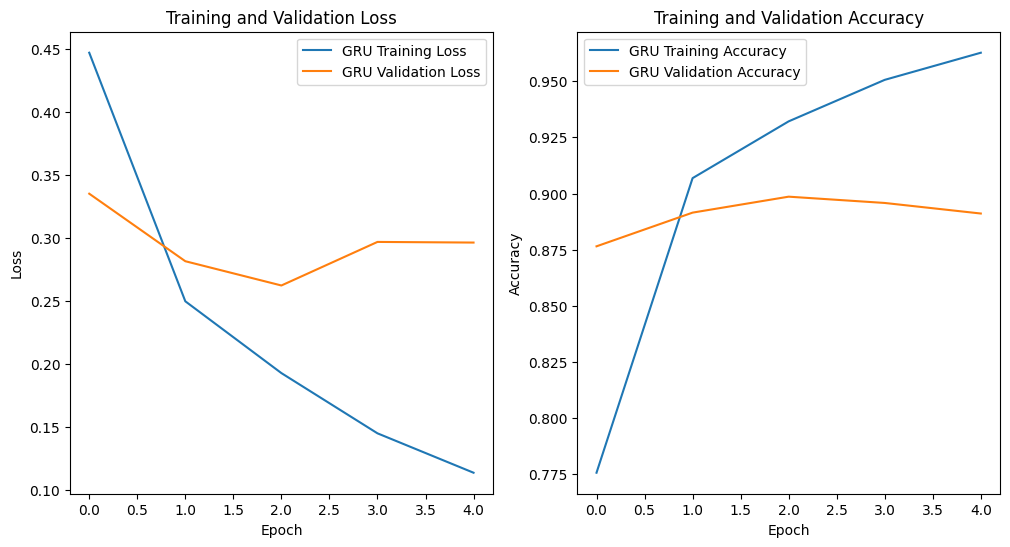

In [40]:
# Plot losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')
#plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
#plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
#plt.plot(tanh_history.history['loss'], label='Tanh Training Loss')
#plt.plot(tanh_history.history['val_loss'], label='Tanh Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(gru_history.history['accuracy'], label='GRU Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Validation Accuracy')
#plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
#plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
#plt.plot(tanh_history.history['accuracy'], label='Tanh Training Accuracy')
#plt.plot(tanh_history.history['val_accuracy'], label='Tanh Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()